# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
from sklearn.model_selection import train_test_split

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train, sizes_train, coords_train = (train['features'], 
            train['labels'], train['sizes'], train['coords'])
X_test, y_test, sizes_test, coords_test = (test['features'], 
            test['labels'], test['sizes'], test['coords'])

#Load CSV for key/label mappings
import csv
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    labels_list = list(map(tuple, reader))
    #remove first tuple which is only a header
    labels_list = labels_list[1:]
    labels_dict = {k:v for k,v in labels_list}
    named_y_train = [labels_dict[str(y)] for y in set(y_train)]

In [2]:
#Step 0 Testing Block

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

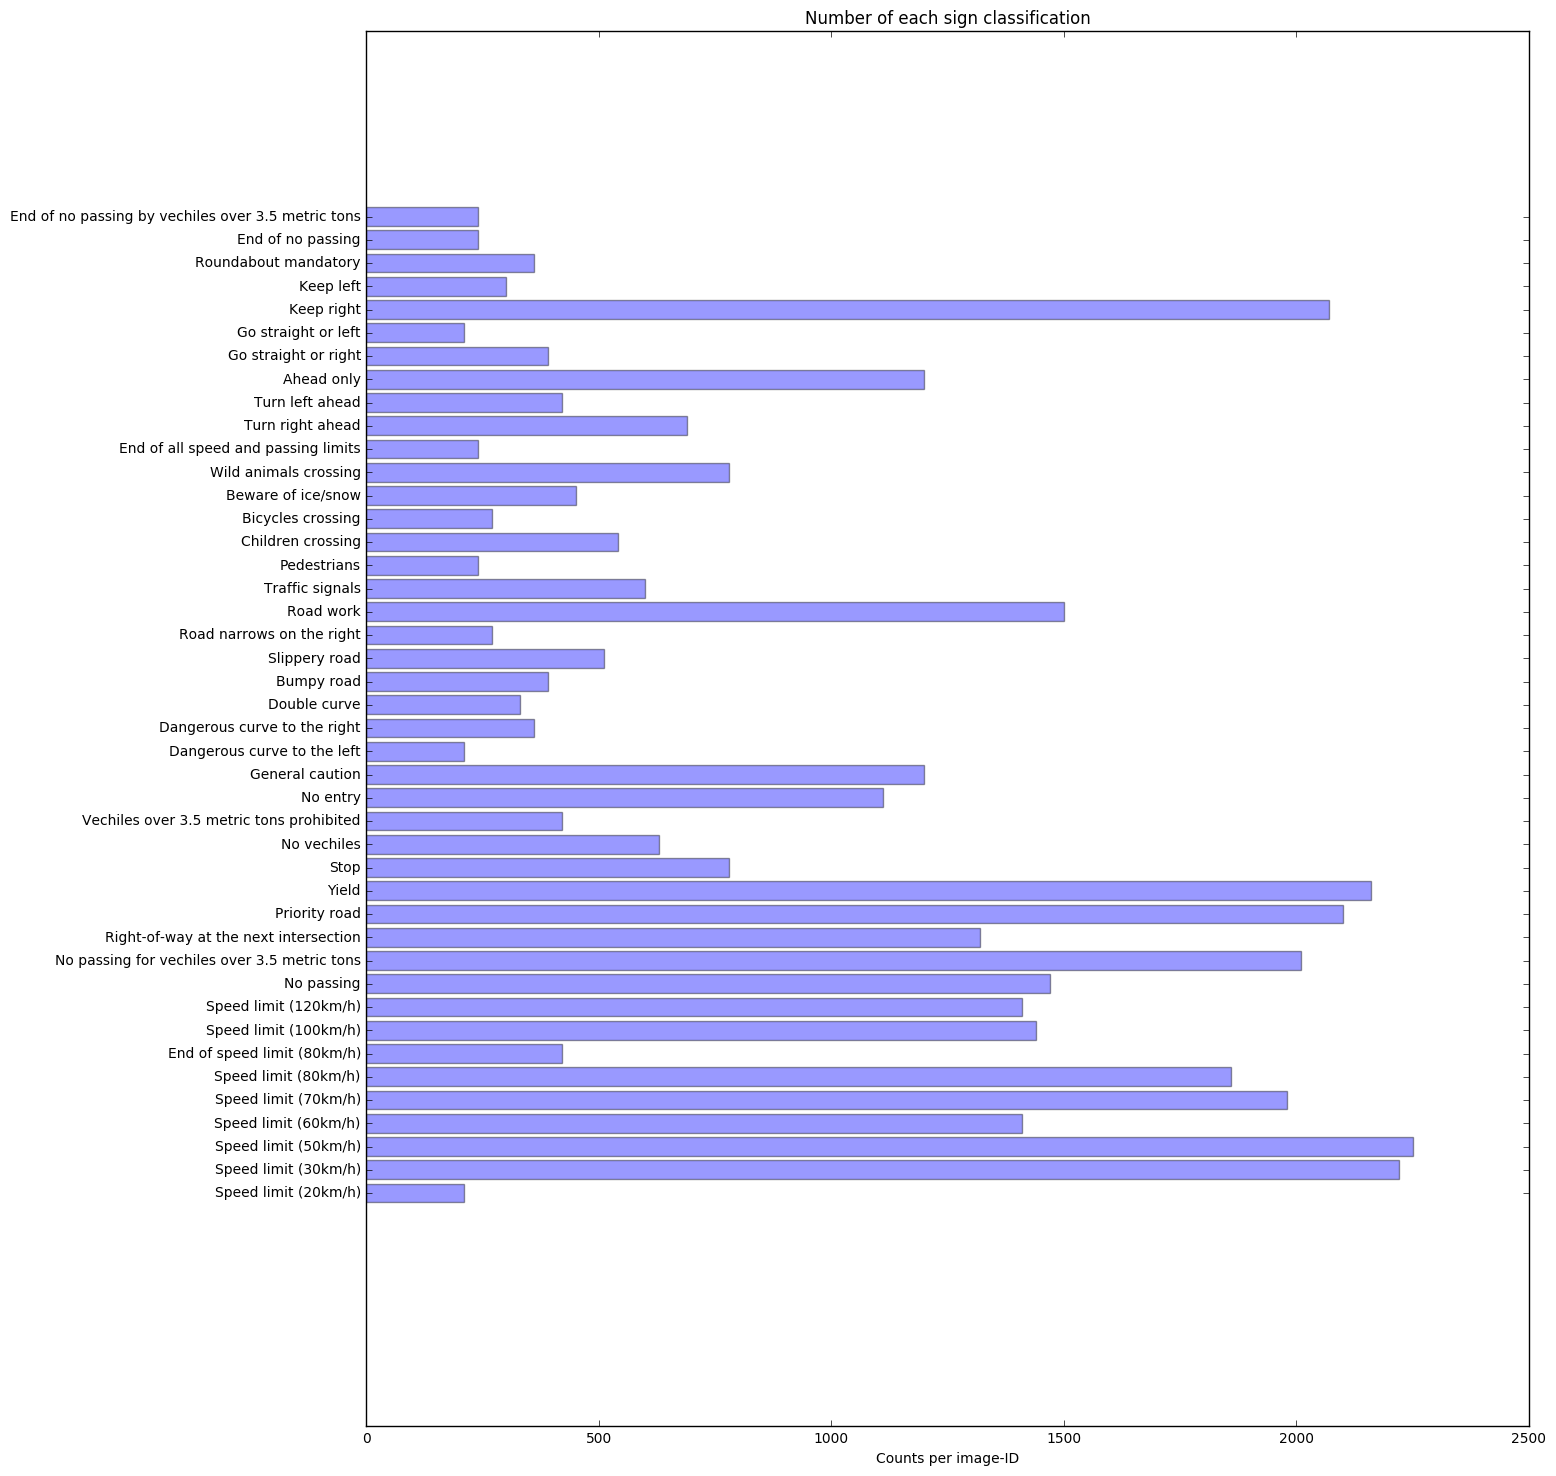

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import matplotlib.pyplot as plt
import numpy as np
import collections
# Visualizations will be shown in the notebook.
%matplotlib inline
plt.rcParams["figure.figsize"] = (15.0, 18.0)

# get the counts for each key, assuming the values are numerical
y_pos,signCounts = np.unique(y_train, return_counts = True)

#map label numbers to values in CSV
#BarH plots count of each sign
plt.barh(y_pos, signCounts, align='center', alpha=0.4)
plt.yticks(y_pos, named_y_train)
plt.xlabel('Counts per image-ID')
plt.title('Number of each sign classification')

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
from scipy.misc import imresize, imrotate
import cv2
%matplotlib inline

#crops a numpy of raw images
def crop(image, box, src):
    imshape = image.shape[:2]
    src_img = cv2.resize(image, tuple(src))
    x1, y1, x2, y2 = box
    src_img = src_img[y1:y2,x1:x2]
    
    try:
        dst_img = cv2.resize(src_img, imshape)
    except:
        dst_img = image
    return dst_img

X_train = [crop(image, box, src) for image, box, src in zip(X_train, coords_train, sizes_train)]
X_test = [crop(image, box, src) for image, box, src in zip(X_test, coords_test, sizes_test)]


In [6]:
#test/train/val
#create validation set by splitting training into train + validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [7]:
# Testing code block

#for i in range(10):
#    plt.figure(figsize=(1,1))
#    plt.imshow(X_test[i])

In [8]:
#Greyscale
def greyscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
X_train = np.array([greyscale(image) for image in X_train], dtype=np.float32)
X_test = np.array([greyscale(image) for image in X_test], dtype=np.float32)
X_val = np.array([greyscale(image) for image in X_val], dtype=np.float32)

In [9]:
#Normalize
def normalize(image): 
    return cv2.normalize(image, None, 0.0, 1.0, cv2.NORM_MINMAX)
X_train = np.array([normalize(image) for image in X_train], dtype=np.float32)
X_test = np.array([normalize(image) for image in X_test], dtype=np.float32)
X_val = np.array([normalize(image) for image in X_val], dtype=np.float32)

In [10]:
#Shuffle
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)
X_val, y_val = shuffle(X_val, y_val)

#Expand to 48x48
size = 48
X_train = np.array([cv2.resize(image, (size,size)) for image in X_train], dtype=np.float32)
X_test = np.array([cv2.resize(image, (size,size)) for image in X_test], dtype=np.float32)
X_val = np.array([cv2.resize(image, (size,size)) for image in X_val], dtype=np.float32)

# Test data cohesion
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))
assert(len(X_val) == len(y_val))

#print(X_train.shape)
#print(X_test.shape)
#print(X_val.shape)
#print(type(X_train))

## Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** My preprocessing consisted of 7 steps.

**Crop**: I cropped the images to the boundary box and the reshaped the image back to its input dimensions. The reason I did this is to improve generalization and accuracy and prevent overfitting. The data around the signs in the original images might be trained to identify the sign even though it doesn't generalize so cropping is useful to get rid of this.

**Split**: Originally the data came in train and test sets only. So to get a validation set I split some of the training data (20% witheld) to make that a validation set. I needed to do this because the test set has to be only run after my model is done. I need a way to validate progress between epochs so taking a little of the training set is needed.

**Grayscale**: I found that grayscaling the images improved results so I did it. It's because luminance is more important for distinguishing visual features. By grayscaling the images edges and other info is more prominant and the network can be simpler.

**Normalize**: I normalized the images after so that the data is more centred around the mean with less variance. By having all the information centered on a distribution of 0-1 the relevant identifiable features are closer together and easier for my architecture to find.

**Shuffle**: The data is shuffled so order doesn't affect the learning. It is also shuffled between epochs.

**Expand**: Even though I'm only sending in grayscale images with 1 channel (which was dropped during processing) the tensorflow varibles and architecture need to have the channel dimension so I readd the dimension by expanding.

**Test**: Lastly, I quickly test that all X,y pairs are the same size

In [11]:
# Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

#Data already split into train/test/validation afte crop processing

from scipy.ndimage import shift, zoom, rotate
from numpy import random
import math

#Function executes during runtime to return perturbed Batches
#args: srcImg - source arraylike
#      srcLabels - source arraylike Img companion labels
#      newAmt - percentage of data to increase by
#      transPerc - percentage for rand translation
#      scalePerc - percentage for rand scaling
#      degRot - deg for rand rotation
def makeMoreImg(srcImg, srcLabels, batch, transPerc, scalePerc, degRot):
    def modImg(img, tP, sP, dR):
        img = img.squeeze()
        width = img.shape[0]
        xtrans = random.uniform(-tP*width,tP*width)
        ytrans = random.uniform(-tP*width,tP*width)
        img = shift(img, (xtrans, ytrans))
        zoomAMT = (1.0-sP)+2*sP*random.random()
        ishape = img.shape[:2]
        img = imresize(img, (int(ishape[0]*zoomAMT),int(ishape[1]*zoomAMT)))
        img = rotate(img, random.randint(-dR,dR))
        img = imresize(img, (48,48))
        img = normalize(img)
        return img       
    
    #shuffle
    srcImg, srcLabels = shuffle(srcImg, srcLabels)
    #copy first x (newAmt) from src(s) and put into temp lists
    extraImg = srcImg[:batch]
    extraLabels = srcLabels[:batch]
    
    #do imgMod/Perturbs
    extraImg = [modImg(image, transPerc, scalePerc, degRot) for image in extraImg]
    
    extraImg = np.expand_dims(extraImg, axis=3)
    return extraImg, extraLabels

# Old Code for NON-RUNTIME
#print("Old X_train length",len(X_train))
#X_train, y_train = makeMoreImg(X_train, y_train, BATCH_SIZE, 0.1, 0.1, 5)
#print("New X_train length", len(X_train))

In [12]:
#add depth channel back
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_val = np.expand_dims(X_val, axis=3)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** In my preprocessing section I split the training data and cut out a 20% random validation set. I will use the other 80% to train and the original testing set for final test after my model is complete.

I decided to generate additional data by taking the original data set and applying to each image in the additional data; a random translation of +/- 10% of the image size, a random scale of +/- 10%, and a random rotation of +/- 5deg. I then normalized and brought back to original dimension.

In [13]:
from tensorflow.contrib.layers import flatten

EPOCHS = 50
BATCH_SIZE = 100
rate = 0.001
dropout = 0.6

In [14]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
#I/O formula (in - out + 2*pad)/S + 1
import tensorflow as tf
# INPUT -> CONV -> ACT -> POOL -> CONV -> ACT -> POOL -> FLATTEN -> FC -> ACT -> FC
def goNet(x):
    #Hyperparameters
    mu = 0
    sigma = 0.05
    
    #in 48x48x1 out 42x42x100
    conv1_W = tf.Variable(tf.truncated_normal(shape=(7,7,1,100), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.constant(0.05, shape=[100]))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    #ACTIVATION
    conv1 = tf.nn.relu(conv1)

    #in 42x42x100 out 21x21x100
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #in 21x21x100 out 18x18x150
    conv2_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 100, 150), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.constant(0.05, shape=[150]))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    #ACTIVATION
    conv2 = tf.nn.relu(conv2)

    #in 18x18x150 out 9x9x150
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #in 9x9x150 out 6x6x250
    conv3_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 150, 250), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.constant(0.05, shape=[250]))
    conv3 = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    #ACTIVATION
    conv3 = tf.nn.relu(conv3)
    
    #in 6x6x250 out 3x3x250
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    fc1 = flatten(conv3)
    fc1_shape = (fc1.get_shape().as_list()[-1], 300)

    #in 2250 out 300
    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc1_shape), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.constant(0.05, shape=[300]))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
 
    #Dropout Layer
    h_fc1_drop = tf.nn.dropout(fc1, keep_prob)

    #in 300 out 42
    fc3_W = tf.Variable(tf.truncated_normal(shape=(300, 43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.constant(0.05, shape=[43]))
    logits = tf.matmul(h_fc1_drop, fc3_W) + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The final architecture I modelled after Ciresan,Meier,Masci,Schmidhuber network "Multi-Column Deep Neural Network for Traffic Sign Classification"

It does not have the multi-column paralellism that they use but their basic DNN structure is the same as mine. It has the following layers:

input 48x48x3

conv1 42x42x100 kernel 7x7

maxpool 21x21x100 kernel 2x2

conv2 18x18x150 kernel 4x4

maxpool 9x9x150 kernel 2x2

conv3 6x6x250 kernel 4x4

maxpool 3x3x250 kernel 2x2

FC 300 kernel 1x1

Dropout Layer (keep_prob passed in)

FC 43 kernel 1x1

In [15]:
#Features and Labels

# 38x38x1
x = tf.placeholder(tf.float32, (None,48,48,1))
# Classify over 10 digits 0-6
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y,43)
# Dropout placeholder
keep_prob = tf.placeholder(tf.float32)

In [16]:
#Training Pipeline

logits = goNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation) 

In [17]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [18]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    prev_valid_accuracy = None
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = makeMoreImg(X_train, y_train, BATCH_SIZE, 0.1, 0.1, 5)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
       
        validation_accuracy = evaluate(X_val, y_val)
        print("EPOCH {} ...".format(i+1))
        if prev_valid_accuracy and prev_valid_accuracy > validation_accuracy:
            #model completed. saving   
            saver.save(sess, 'goNet')
            print("Model saved")
            break;
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        prev_valid_accuracy = validation_accuracy


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Training...

EPOCH 1 ...
Validation Accuracy = 0.920

EPOCH 2 ...
Validation Accuracy = 0.947

EPOCH 3 ...
Validation Accuracy = 0.956

EPOCH 4 ...
Model saved


In [19]:
#Evaluate the Model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.889


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** I used the Atom optimizer from tensorflow. This is the same one that was used in Lenet and is similar to gradient descent. For batch size I found that somewhere between 100-120 seemed to give me the best results in the fewest Epochs. I settled on 100 and found through trial and error that by raising my dropout just a tad to 0.6 probability it was better. Through subsequent higher epoch tests I discovered that I was averaging about 3-4 productive epochs before a drop. For robustness I decided to make epochs variable to reduce overfitting by breaking out on a decrease in validation. My learning rate is a standard 0.001 and I put constant bias of 0.05 on my layers.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** I started out with the Lenet5 architecture to solve the problem. I thought that would be suitable because on the surface it was classifying similar data. It was meant for classifying letter images in the MNIST. I was able to get around 70-80% validation accuracy with that setup using pretty default and conservative parameters although perhaps it should have been better but I had a bug in my last FC output layer for a while. Regardless, I then asked my mentor and researched for other alternatives. My mentor forwarded me to a research paper *Ciresan,Meier,Masci,Schmidhuber network "Multi-Column Deep Neural Network for Traffic Sign Classification"*. In that paper was described an award winning Traffic Sign Classifier based on a Multiple Deep networks running seperately on different preprocessing of images, and then combined. I decided I would only try to emulate their basic architecture and then try my own tuning. I replaced my LeNet architecture with their design (shown in Arch question above) and began to input my images as 48x48. I got over 90% with this setup. From there I tried just experiment with inputs. My goal was to get 95+ on the validation sets. I decided to crop the images and also did the optional image generation to get more data and have peturbations and skewing. I was hitting 92-94 on average with that but there fluctuations between epochs. I was pretty happy with the architecture at that point so just did a lot of trial and error with the hyperparameters. I kept going until I had a fairly stable, high validation result.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [20]:
# TESTING
# import matplotlib.pyplot as plt
# import numpy as np
# #Test Display of Signs to Maps
# print(np.where(y_train==1)[0][0])
# for i in range(43):
#     index = np.where(y_train==i)[0][0]
#     %matplotlib inline
#     plt.figure(figsize=(1,1))
#     plt.imshow(X_train[index])
#     print(i, " ", labels_dict[str(y_train[index])])
#     print()   


Test Accuracy = 0.200


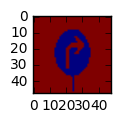

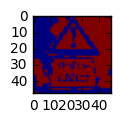

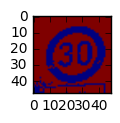

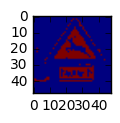

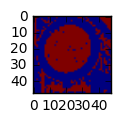

In [24]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from scipy.ndimage import imread
import os
#Create X_web and y_web numpy
files=[]
for file in os.listdir("."):
    if file.endswith(".jpg"):
        files.append(file)
        
#print(files)
def processweb(infile):
    img = imread(infile)
    img = greyscale(img)
    img = normalize(img)
    img = cv2.resize(img,(48,48))
    return img

X_web = np.array([processweb(file) for file in files])

%matplotlib inline
for image in X_web:
    plt.figure(figsize=(1,1))
    plt.imshow(image)

X_web = np.expand_dims(X_web, axis=3)
y_web = np.array([33,18,1,31,15])

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    web_accuracy = evaluate(X_web, y_web)
    print("Test Accuracy = {:.3f}".format(web_accuracy))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [22]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [23]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.